<a href="https://colab.research.google.com/github/Lexaun-chen/STAT-4830-Group-Project/blob/main/notebooks/Plot_Deep_MNL_with_feature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.nn as nn


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/STAT4830 Group Project/Week4

/content/drive/MyDrive/STAT4830 Group Project/Week4


In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU available:", device)
    torch.cuda.init()
else:
    device = torch.device("cpu")
    print("GPU unavailable: CPU")

GPU available: cuda


In [ ]:
class Sales:
    def __init__(self, all_offer_sets, sell_num, mask):
        self.offer_set_list = []
        self.fw = None
        self.N_sales = torch.tensor(np.concatenate(sell_num, axis=1), dtype=torch.float64, device=device)
        self.offer_feature = torch.tensor(all_offer_sets, dtype=torch.float64)
        self.original_shape = self.offer_feature.shape
        self.feature_concat = self.offer_feature.reshape(-1, self.offer_feature.shape[2]).to(device)
        self.N = len(all_offer_sets)
        self.mask = torch.tensor(mask, dtype=torch.float64, device=device)
        self.mask_flat = self.mask.reshape((-1,))
        self.masked_feature_concat = self.feature_concat[self.mask_flat == 1]

    def calculate_all_choice_prob(self, W):
        rule_feature = self.feature_concat
        self.fw = self.calculate_choice_prob(rule_feature, W)
        return self.fw

    def calculate_choice_prob(self, rule_feature, W):
        Z = W(rule_feature).reshape(self.original_shape[:2])
        masked_Z = Z.masked_fill(self.mask == 0, float('-inf'))
        softmax_result = F.softmax(masked_Z, dim=-1).reshape((-1, 1))[self.mask_flat == 1]
        return softmax_result

In [ ]:
class Deep_MNL(nn.Module):
    def __init__(self, input_dim):
        super(Deep_MNL, self).__init__()
        self.layer1 = nn.Linear(input_dim, 100, dtype=torch.float64, bias=False).to(device)
        self.layer2 = nn.Linear(100, 100, dtype=torch.float64, bias=False).to(device)
        self.layer3 = nn.Linear(100, 1, dtype=torch.float64, bias=False).to(device)
        # self._initialize_weights()

    def _initialize_weights(self):
        nn.init.constant_(self.layer1.weight, 0)
        nn.init.constant_(self.layer1.bias, 0)
        nn.init.constant_(self.layer2.weight, 0)
        nn.init.constant_(self.layer2.bias, 0)
        nn.init.constant_(self.layer3.weight, 0)
        nn.init.constant_(self.layer3.bias, 0)

    def forward(self, x):
        x = self.layer1(x)
        x = torch.sigmoid(x)
        x = self.layer2(x)
        x = torch.sigmoid(x)
        x = self.layer3(x)
        return x

In [ ]:
class Problem_MNL:
    def __init__(self, S, N, M): #Option set, Number of sales, Mask
        self.W = None
        self.sales = Sales(S, N, M)
        # Define and initialize the ruleset
        self.feature_num = S.shape[-1]
        # Put the feature to the GPU
        self.sales.feature_concat = self.sales.feature_concat.to(device)
        # Define a consumer list that contain consumer types
        self.consumer_list = []
        # Define the main problem NLL loss
        self.NLL_main = None
        # Define the current likelihood convex combination
        self.g = None
        # Define the current likelihood gradient for support finding
        self.NLL_gradient = None
        # Define a list to contain all fw choice likelihood
        self.fw_list = []
        # Define a new sales data for further estimation
        self.sales_estimate = None

    def loss(self, W):
        N = self.sales.N
        N_sales = self.sales.N_sales
        normalize_term = torch.tensor(1 / N, dtype=torch.float64, device=device)
        fw = self.sales.calculate_all_choice_prob(W)
        fw_log = torch.log(fw)
        return -normalize_term * torch.matmul(N_sales, fw_log)

    def optimize_w(self):
        encoder = Deep_MNL(14).to(device)  # Move the entire model to the device
        self.W = encoder
        loss_previous = 1e10000
        optimizer = optim.Adam(encoder.parameters(), lr=5e-5)
        optimizer.zero_grad()
        NLL_list = []
        # early_stop_count = 0
        epoches = 3000
        test_loss_list = []
        for epoch in range(epoches):
            LOSS = self.loss(encoder)
            LOSS.backward()
            optimizer.step()
            if (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch + 1}/{epoches}], Loss: {LOSS.item():.4f}')
            loss_current = LOSS.item()
            # if loss_current < loss_previous:
            #     loss_previous = loss_current
            # else:
            #     early_stop_count += 1
            #     if early_stop_count > 0:
            #         break
            NLL_list.append(loss_current)
            test_loss = self.estimate(te_offerset_list, te_sell_list, te_mask_list)
            test_loss_list.append(test_loss.item())
        return NLL_list, test_loss_list


    def estimate(self, S, N, M):
        sales_estimate = Sales(S, N, M)
        N = sales_estimate.N
        N_sales = sales_estimate.N_sales
        normalize_term = torch.tensor(1 / N, dtype=torch.float64, device=device)
        fw = sales_estimate.calculate_all_choice_prob(self.W)
        fw_log = torch.log(fw)
        return -normalize_term * torch.matmul(N_sales, fw_log)

In [ ]:
def get_offer_data(data_para):
    offerset_list = []
    sell_list = []
    mask_list = []
    max_num = 32
    for srch_id, group in data_para:
        num_product = len(group)
        offerset = group.drop(columns=['booking_bool', 'srch_id']).values
        offer_dummy = np.zeros((max_num - num_product, offerset.shape[1]))
        offerset = np.vstack((offerset, offer_dummy)) #Padding Offer Sets
        offer_mask = np.append(np.ones(num_product), np.zeros(max_num - num_product)) # Mask for 0 from padding

        # if group['booking_bool'].sum() == 0: # No hotel reservations
        #     num_sell = np.append(group['booking_bool'].values, 1).reshape(1, -1) # Create and Select "not buy" option
        # else:
        #     num_sell = np.append(group['booking_bool'].values, 0).reshape(1, -1)

        num_sell = group['booking_bool'].values.reshape(1, -1)
        offerset_list.append(offerset)
        sell_list.append(num_sell)
        mask_list.append(offer_mask)

    offerset_list = np.array(offerset_list)
    mask_list = np.array(mask_list)
    return offerset_list, sell_list, mask_list


search_info = ['srch_id']
feature = ['position', 'prop_starrating',
           'prop_location_score1', 'prop_log_historical_price',
           'prop_brand_bool', 'promotion_flag', 'srch_booking_window', 'srch_length_of_stay',
           'srch_adults_count', 'srch_children_count', 'srch_room_count',
           'srch_saturday_night_bool', 'price_usd', 'random_bool', 'booking_bool']

tr_data = pd.read_csv('train_28-32_10000.csv')
te_data = pd.read_csv('test_28-32_1000.csv')
tr_data = tr_data[search_info + feature]
te_data = te_data[search_info + feature]
tr_offerset_list, tr_sell_list, tr_mask_list = get_offer_data(tr_data.groupby('srch_id'))
te_offerset_list, te_sell_list, te_mask_list = get_offer_data(te_data.groupby('srch_id'))

Epoch [10/3000], Loss: 3.4306
Epoch [20/3000], Loss: 3.4287
Epoch [30/3000], Loss: 3.4266
Epoch [40/3000], Loss: 3.4244
Epoch [50/3000], Loss: 3.4221
Epoch [60/3000], Loss: 3.4197
Epoch [70/3000], Loss: 3.4172
Epoch [80/3000], Loss: 3.4147
Epoch [90/3000], Loss: 3.4120
Epoch [100/3000], Loss: 3.4093
Epoch [110/3000], Loss: 3.4065
Epoch [120/3000], Loss: 3.4036
Epoch [130/3000], Loss: 3.4006
Epoch [140/3000], Loss: 3.3975
Epoch [150/3000], Loss: 3.3943
Epoch [160/3000], Loss: 3.3909
Epoch [170/3000], Loss: 3.3874
Epoch [180/3000], Loss: 3.3837
Epoch [190/3000], Loss: 3.3799
Epoch [200/3000], Loss: 3.3759
Epoch [210/3000], Loss: 3.3717
Epoch [220/3000], Loss: 3.3673
Epoch [230/3000], Loss: 3.3627
Epoch [240/3000], Loss: 3.3578
Epoch [250/3000], Loss: 3.3528
Epoch [260/3000], Loss: 3.3475
Epoch [270/3000], Loss: 3.3419
Epoch [280/3000], Loss: 3.3359
Epoch [290/3000], Loss: 3.3296
Epoch [300/3000], Loss: 3.3230
Epoch [310/3000], Loss: 3.3161
Epoch [320/3000], Loss: 3.3088
Epoch [330/3000],

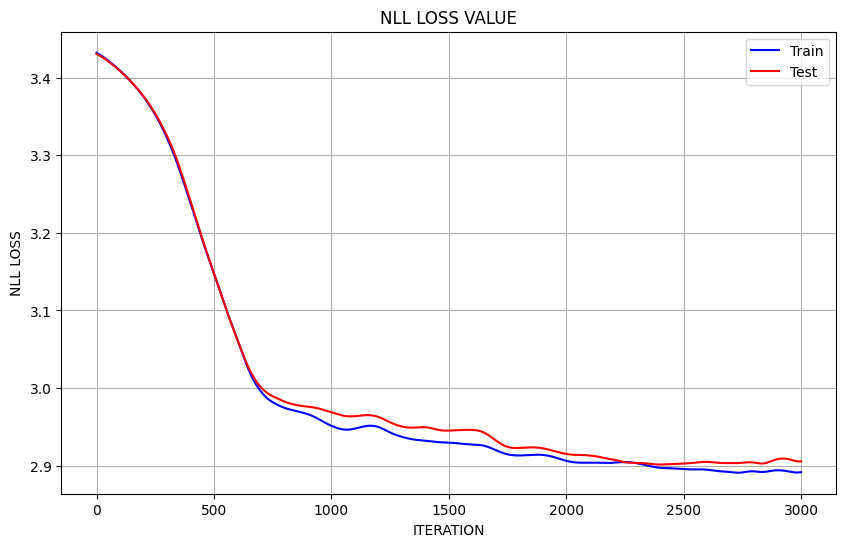

In [ ]:
def train_MNL():
    problem = Problem_MNL(tr_offerset_list, tr_sell_list, tr_mask_list)
    NLL_list, tl = problem.optimize_w()
    return problem, NLL_list, tl

MNL_problem, NLL_LIST, NLL_LIST_TEST = train_MNL()
plt.figure(figsize=(10, 6))
plt.plot(NLL_LIST, linestyle='-', color='b', label='Train')
plt.plot(NLL_LIST_TEST, linestyle='-', color='r', label='Test')
plt.title('NLL LOSS VALUE')
plt.xlabel('ITERATION')
plt.ylabel('NLL LOSS')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print('Test Loss: ', MNL_problem.estimate(te_offerset_list, te_sell_list, te_mask_list))
print('Train Loss: ', MNL_problem.estimate(tr_offerset_list, tr_sell_list, tr_mask_list))

Test Loss:  tensor([[2.9055]], device='cuda:0', dtype=torch.float64,
       grad_fn=<MulBackward0>)
Train Loss:  tensor([[2.8916]], device='cuda:0', dtype=torch.float64,
       grad_fn=<MulBackward0>)


In [ ]:
torch.save(MNL_problem.W.state_dict(), 'deep_mnl_model_depth2_100.pth')